In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
resize_layer_64 = tf.keras.Sequential([
    Resizing(64, 64),
])

In [6]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']  
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 209.75it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.10it/s]


In [8]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [9]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [10]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [11]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

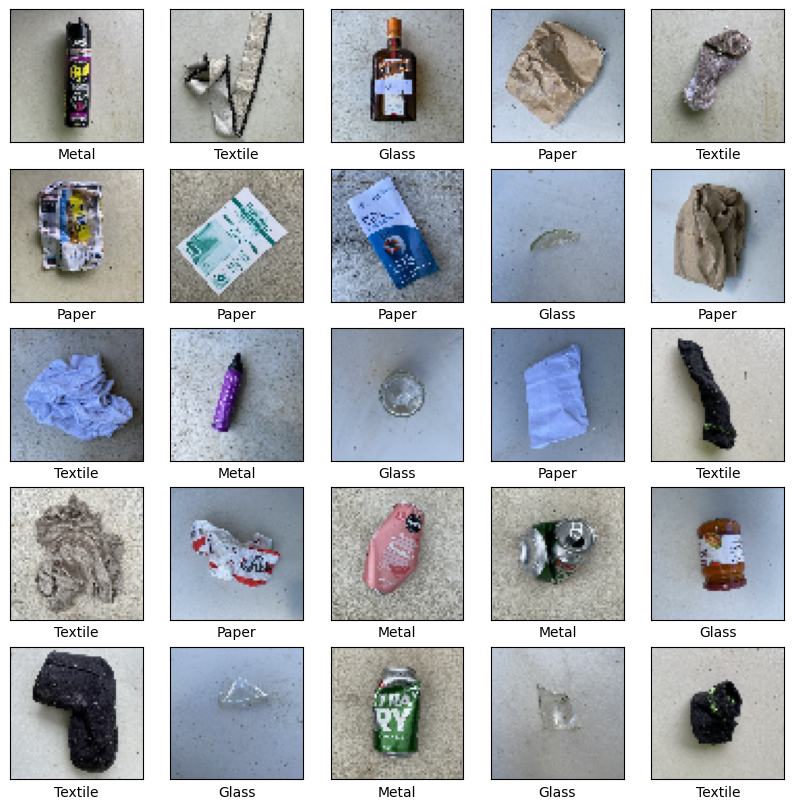

In [12]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),                                                      
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 300,164 (1.15 MB)

 Trainable params: 299,460 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [15]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation ='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.01), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.05), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.05), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 236,452 (923.64 KB)

 Trainable params: 235,876 (921.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [16]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [17]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [19]:
#Learning rate scheduler for Model 3

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [20]:
# Set number of epochs
epochs = 150
batch_size = 64

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-09 14:30:56.054127

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3488 - loss: 17.8131
Epoch 1: val_accuracy improved from -inf to 0.31944, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.3619 - loss: 17.5608 - val_accuracy: 0.3194 - val_loss: 13.1989 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6382 - loss: 12.1656
Epoch 2: val_accuracy improved from 0.31944 to 0.34259, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6385 - loss: 12.1292 - val_accuracy: 0.3426 - val_loss: 10.8150 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8624 - loss: 2.0088 - val_accuracy: 0.2639 - val_loss: 5.5135 - learning_rate: 0.0015

Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8908 - loss: 1.9329
Epoch 20: val_accuracy did not improve from 0.38889
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8875 - loss: 1.9414 - val_accuracy: 0.2639 - val_loss: 5.3339 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8491 - loss: 2.0736
Epoch 21: val_accuracy did not improve from 0.38889
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8491 - loss: 2.0731 - val_accuracy: 0.2639 - val_loss: 5.3296 - learning_rate: 0.0015

Epoch 22: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 22/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accurac


Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9654 - loss: 0.9898
Epoch 39: val_accuracy did not improve from 0.41204
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9657 - loss: 0.9892 - val_accuracy: 0.3796 - val_loss: 2.3333 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9706 - loss: 0.9400
Epoch 40: val_accuracy did not improve from 0.41204
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9706 - loss: 0.9395 - val_accuracy: 0.3380 - val_loss: 2.4270 - learning_rate: 9.4537e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008981053746538237.
Epoch 41/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9541 - loss: 0.9445
Epoch 41: val_accuracy did not improve from 0.41204
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9768 - loss: 0.5971 - val_accuracy: 0.7824 - val_loss: 1.0906 - learning_rate: 4.1608e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9882 - loss: 0.5842
Epoch 57: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9881 - loss: 0.5832 - val_accuracy: 0.7639 - val_loss: 1.0975 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9934 - loss: 0.5448
Epoch 58: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9932 - loss: 0.5446 - val_accuracy: 0.7407 - val_loss: 1.1043 - learning_rate: 3.7552e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00035674029641086236.
Epoch 59/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 70

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9913 - loss: 0.4449
Epoch 75: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9915 - loss: 0.4435 - val_accuracy: 0.7824 - val_loss: 0.8333 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9916 - loss: 0.4120
Epoch 76: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9916 - loss: 0.4119 - val_accuracy: 0.7963 - val_loss: 0.8205 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9857 - loss: 0.4103
Epoch 77: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9853 - loss: 0.4108 - val_accuracy: 0.7870 - val_loss: 0.8569 - learning_rate: 1.4170e-04


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9984 - loss: 0.3503 - val_accuracy: 0.8241 - val_loss: 0.7789 - learning_rate: 6.2367e-05

Epoch 94: LearningRateScheduler setting learning rate to 5.924862780375406e-05.
Epoch 94/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9932 - loss: 0.3550
Epoch 94: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9931 - loss: 0.3548 - val_accuracy: 0.8241 - val_loss: 0.7734 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9929 - loss: 0.3528
Epoch 95: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9928 - loss: 0.3533 - val_accuracy: 0.8148 - val_loss: 0.7673 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68m

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9970 - loss: 0.3306
Epoch 112: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9965 - loss: 0.3311 - val_accuracy: 0.8102 - val_loss: 0.7638 - learning_rate: 2.3534e-05

Epoch 113: LearningRateScheduler setting learning rate to 2.2357684792950748e-05.
Epoch 113/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9920 - loss: 0.3321
Epoch 113: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9920 - loss: 0.3323 - val_accuracy: 0.8102 - val_loss: 0.7555 - learning_rate: 2.2358e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.1239800207695226e-05.
Epoch 114/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9884 - loss: 0.3376
Epoch 114: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9889 - loss: 0.3374 - val_accuracy: 0.8241 - val_loss: 0.7621 - learning_rate: 2.12

Epoch 131/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9941 - loss: 0.3324
Epoch 131: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9939 - loss: 0.3324 - val_accuracy: 0.8194 - val_loss: 0.7593 - learning_rate: 8.8808e-06

Epoch 132: LearningRateScheduler setting learning rate to 8.436753205387504e-06.
Epoch 132/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9955 - loss: 0.3237
Epoch 132: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9956 - loss: 0.3236 - val_accuracy: 0.8194 - val_loss: 0.7612 - learning_rate: 8.4368e-06

Epoch 133: LearningRateScheduler setting learning rate to 8.014915329113137e-06.
Epoch 133/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.3248
Epoch 133: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9943 - loss: 0.3248 - val_accuracy: 0.8148 - val_loss: 0.7594 - learnin

Epoch 150/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9837 - loss: 0.3318
Epoch 150: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9846 - loss: 0.3312 - val_accuracy: 0.8241 - val_loss: 0.7525 - learning_rate: 3.3512e-06
Time model end: 2024-11-09 14:33:45.200628
Model_1_training_time 0:02:49.146501


In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-09 14:33:45.207560

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4060 - loss: 15.8048
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.4122 - loss: 15.7764 - val_accuracy: 0.2639 - val_loss: 15.0225 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6879 - loss: 14.2826
Epoch 2: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.6866 - loss: 14.2723 - val_accuracy: 0.2639 - val_loss: 14.2401 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6602 - loss: 13.2460
Epoch 3:


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8733 - loss: 2.9128
Epoch 20: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.8730 - loss: 2.9102 - val_accuracy: 0.2639 - val_loss: 4.2008 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9026 - loss: 2.6850
Epoch 21: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9010 - loss: 2.6869 - val_accuracy: 0.2639 - val_loss: 4.1817 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9000 - loss: 2.6110
Epoch 22: val_accuracy improved from 0.26389 to 0.34259, saving model to C:/Mani/ModelCheckpoint/model2.ker


Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9488 - loss: 1.3393
Epoch 39: val_accuracy did not improve from 0.43981
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.9487 - loss: 1.3385 - val_accuracy: 0.3009 - val_loss: 3.1644 - learning_rate: 6.6342e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9569 - loss: 1.2715
Epoch 40: val_accuracy improved from 0.43981 to 0.44444, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.9565 - loss: 1.2723 - val_accuracy: 0.4444 - val_loss: 2.4099 - learning_rate: 6.3025e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005987368611386045.
Epoch 41/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9473 - loss: 1.2467
Epoch 41: val_accuracy did not improve fr


Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9684 - loss: 0.7722
Epoch 57: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.9689 - loss: 0.7721 - val_accuracy: 0.6296 - val_loss: 1.6554 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9876 - loss: 0.7450
Epoch 58: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.9877 - loss: 0.7449 - val_accuracy: 0.7083 - val_loss: 1.4826 - learning_rate: 2.5034e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00023782684584148226.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9802 - loss: 0.7495
Epoch 59: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - acc

Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9944 - loss: 0.5119
Epoch 75: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.9945 - loss: 0.5113 - val_accuracy: 0.8287 - val_loss: 0.9485 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9858 - loss: 0.5139
Epoch 76: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.9862 - loss: 0.5130 - val_accuracy: 0.8380 - val_loss: 0.9575 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9934 - loss: 0.4897
Epoch 77: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.9933 - loss: 0.4897 - val_accuracy: 0.8426 - val_loss: 0.9291 - learning_


Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9980 - loss: 0.4077
Epoch 94: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.9979 - loss: 0.4079 - val_accuracy: 0.8426 - val_loss: 0.8515 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9960 - loss: 0.4076
Epoch 95: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.9961 - loss: 0.4075 - val_accuracy: 0.8287 - val_loss: 0.9006 - learning_rate: 3.7524e-05

Epoch 96: LearningRateScheduler setting learning rate to 3.564792586985277e-05.
Epoch 96/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9989 - loss: 0.4022
Epoch 96: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.9944 - loss: 0.3730 - val_accuracy: 0.8519 - val_loss: 0.7839 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9998 - loss: 0.3732
Epoch 113: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.9998 - loss: 0.3731 - val_accuracy: 0.8519 - val_loss: 0.7787 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9993 - loss: 0.3708
Epoch 114: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.9992 - loss: 0.3709 - val_accuracy: 0.8565 - val_loss: 0.7803 - learning_rate: 1.4160e-05

Epoch 115: LearningRateScheduler setting learning rate to 1.3451874156089615e-05.
Epoch 115/150
14/14 ━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9974 - loss: 0.3593
Epoch 131: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.9974 - loss: 0.3594 - val_accuracy: 0.8426 - val_loss: 0.7745 - learning_rate: 5.9205e-06

Epoch 132: LearningRateScheduler setting learning rate to 5.624501704915019e-06.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9982 - loss: 0.3615
Epoch 132: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.9981 - loss: 0.3615 - val_accuracy: 0.8426 - val_loss: 0.7799 - learning_rate: 5.6245e-06

Epoch 133: LearningRateScheduler setting learning rate to 5.343276598068769e-06.
Epoch 133/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9955 - loss: 0.3600
Epoch 133: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.9953 - loss: 0.3603 - val_accuracy: 0.8426 - val_loss: 0.7812 - learning_rate: 


Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9981 - loss: 0.3592
Epoch 150: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.9980 - loss: 0.3590 - val_accuracy: 0.8472 - val_loss: 0.7663 - learning_rate: 2.2341e-06
Time model end: 2024-11-09 14:44:47.593804
Model_2_training_time 0:11:02.386244


In [23]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-09 14:44:47.602671

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3545 - loss: 19.8507
Epoch 1: val_accuracy improved from -inf to 0.28241, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.3582 - loss: 19.8119 - val_accuracy: 0.2824 - val_loss: 18.2787 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5562 - loss: 17.5977
Epoch 2: val_accuracy did not improve from 0.28241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.5567 - loss: 17.5718 - val_accuracy: 0.2639 - val_loss: 16.7068 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6134 - loss: 15.7955


Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7993 - loss: 2.4279
Epoch 20: val_accuracy did not improve from 0.28241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.7987 - loss: 2.4271 - val_accuracy: 0.2639 - val_loss: 4.2281 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8542 - loss: 2.1659
Epoch 21: val_accuracy did not improve from 0.28241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8535 - loss: 2.1651 - val_accuracy: 0.2639 - val_loss: 4.5832 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8736 - loss: 1.9720
Epoch 22: val_accuracy did not improve from 0.28241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.8986 - loss: 1.2903 - val_accuracy: 0.5324 - val_loss: 2.2407 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9065 - loss: 1.2744
Epoch 39: val_accuracy did not improve from 0.53241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.9052 - loss: 1.2763 - val_accuracy: 0.5139 - val_loss: 2.2090 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8686 - loss: 1.2983
Epoch 40: val_accuracy did not improve from 0.53241
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8688 - loss: 1.2992 - val_accuracy: 0.3241 - val_loss: 3.1856 - learning_rate: 9.8000e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 41/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9737 - loss: 0.8698
Epoch 57: val_accuracy did not improve from 0.64815
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.9728 - loss: 0.8710 - val_accuracy: 0.6343 - val_loss: 1.7370 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9649 - loss: 0.8514
Epoch 58: val_accuracy did not improve from 0.64815
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.9648 - loss: 0.8520 - val_accuracy: 0.5324 - val_loss: 2.0005 - learning_rate: 5.2955e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0005030752246966585.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9688 - loss: 0.8314
Epoch 59: val_accuracy improved from 0.64815 to 0.65741, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.9682 - loss: 0.


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9826 - loss: 0.5775
Epoch 75: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.9827 - loss: 0.5773 - val_accuracy: 0.7546 - val_loss: 1.1554 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9928 - loss: 0.5623
Epoch 76: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.9926 - loss: 0.5625 - val_accuracy: 0.7917 - val_loss: 1.0785 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9912 - loss: 0.5457
Epoch 77: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - a

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9930 - loss: 0.4310
Epoch 93: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.9930 - loss: 0.4311 - val_accuracy: 0.7917 - val_loss: 0.9958 - learning_rate: 8.7950e-05

Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9964 - loss: 0.4267
Epoch 94: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.9962 - loss: 0.4270 - val_accuracy: 0.7963 - val_loss: 0.9637 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9971 - loss: 0.4257
Epoch 95: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.9970 - loss: 0.4260 - val_accuracy: 0.8148 - val_loss: 0.8952 - learning_rate: 7.9375e


Epoch 112: LearningRateScheduler setting learning rate to 3.318822000437649e-05.
Epoch 112/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9988 - loss: 0.3904
Epoch 112: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.9986 - loss: 0.3904 - val_accuracy: 0.8102 - val_loss: 0.8907 - learning_rate: 3.3188e-05

Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9970 - loss: 0.3885
Epoch 113: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.9967 - loss: 0.3887 - val_accuracy: 0.8056 - val_loss: 0.8802 - learning_rate: 3.1529e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.9952368458907584e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9973 - loss: 0.3909
Epoch 114: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/


Epoch 131: LearningRateScheduler setting learning rate to 1.2523694658739258e-05.
Epoch 131/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9989 - loss: 0.3701
Epoch 131: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.9988 - loss: 0.3701 - val_accuracy: 0.7963 - val_loss: 0.8897 - learning_rate: 1.2524e-05

Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9959 - loss: 0.3650
Epoch 132: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9960 - loss: 0.3651 - val_accuracy: 0.7963 - val_loss: 0.8721 - learning_rate: 1.1898e-05

Epoch 133: LearningRateScheduler setting learning rate to 1.1302634857202064e-05.
Epoch 133/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9957 - loss: 0.3657
Epoch 133: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms


Epoch 150: LearningRateScheduler setting learning rate to 4.725861754195648e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9979 - loss: 0.3617
Epoch 150: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step - accuracy: 0.9979 - loss: 0.3618 - val_accuracy: 0.8056 - val_loss: 0.8612 - learning_rate: 4.7259e-06
Time model end: 2024-11-09 14:57:38.390540
Model_3_training_time 0:12:50.787869


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:4.5)')

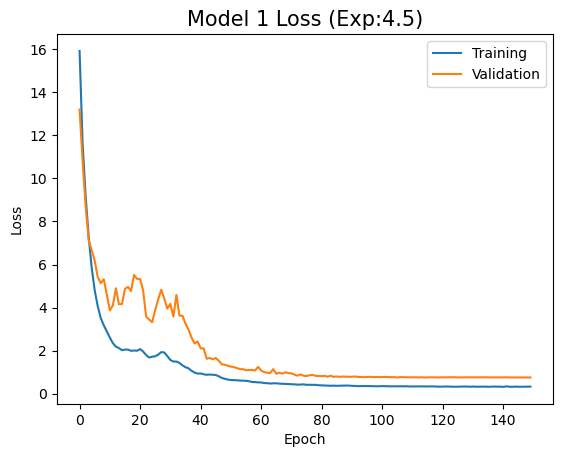

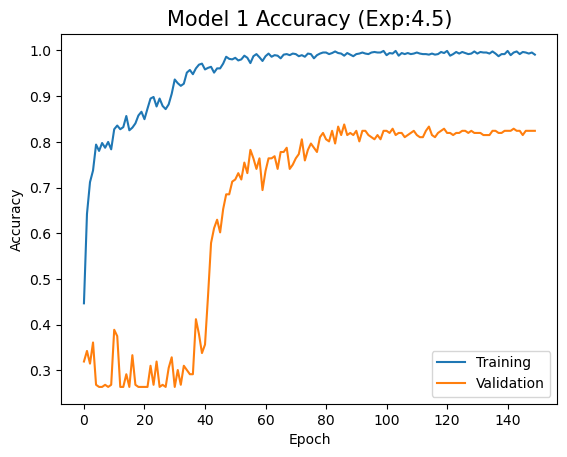

In [24]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:4.5)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:4.5)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:4.5)')

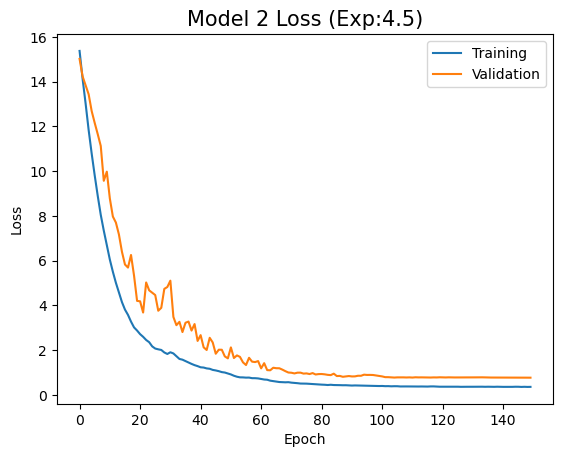

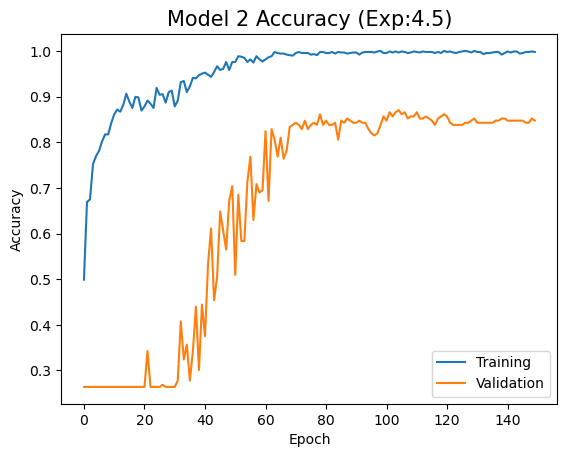

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:4.5)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:4.5)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:4.5)')

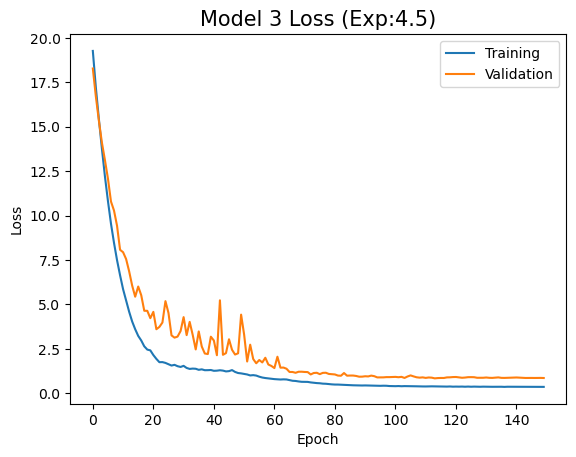

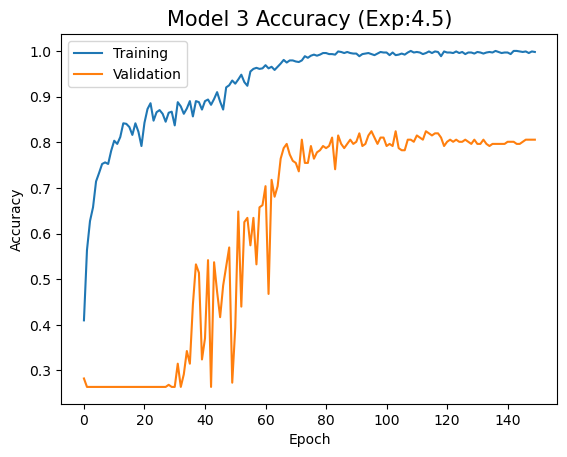

In [26]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:4.5)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:4.5)', fontsize = 15)

In [27]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size=64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size=64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size=64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8014 - loss: 0.8419
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8687 - loss: 0.7871
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8397 - loss: 0.8701


In [28]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


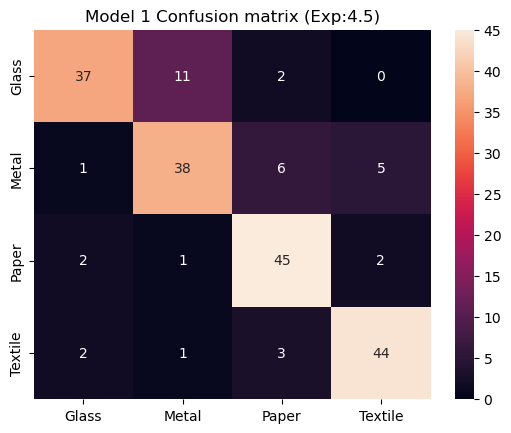

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:4.5)')
plt.show()

In [30]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


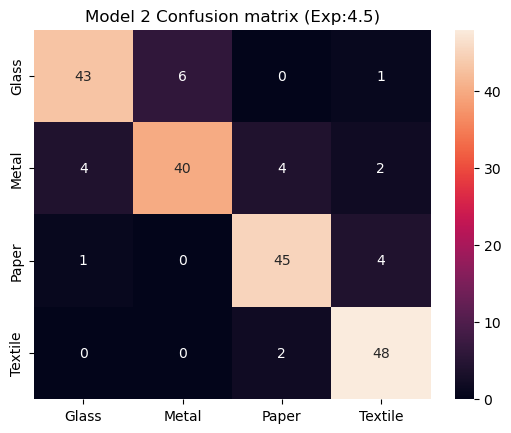

In [31]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:4.5)')
plt.show()

In [32]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


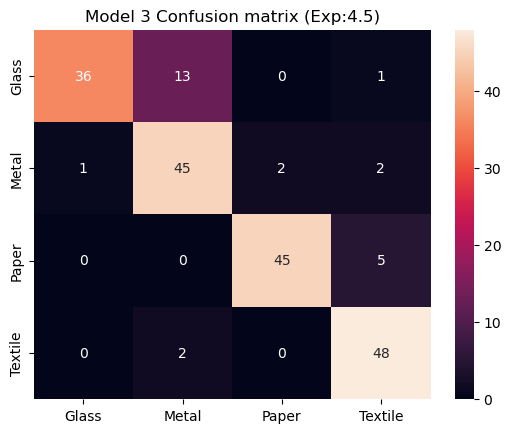

In [33]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:4.5)')
plt.show()